In [1]:
import numpy as np
from filters.filters import IEKF
from datasets import data
from tools.objects import Gaussian
from tools.plot import plot2dcov
import mrob
from matplotlib import pyplot as plt

In [2]:
def ciplot(t, mu, minus_sigma, plus_sigma, x_real, color=None):
    """
    Plots a shaded region on a graph between specified lower and upper confidence intervals (L and U).

    :param t: The time series corresponding to the state.
    :param mu: The predicted state of the variable.
    :param minus_sigma: THe lower bound of the confidence interval.
    :param plus_sigma: The upper bound of the confidence interval.
    :param x_real: The real value of the state variable.
    :param color: Color of the fill inside the lower and upper bound curves (optional).
    :return handle: The handle to the plot of the state variable.
    """

    assert minus_sigma.shape[0] == plus_sigma.shape[0]
    assert t.shape[0] == mu.shape[0]

    plt.fill_between(t, minus_sigma, plus_sigma, color=color, alpha=0.5)
    x_pred, = plt.plot(t, mu)
    x_real, = plt.plot(t, x_real)

    return x_pred, x_real

In [3]:
a = np.eye(3) @ np.ones(3).reshape(-1, 1)
b = np.eye(3) @ np.ones(3).reshape(-1, 1) * 2
c = np.eye(3) @ np.ones(3).reshape(-1, 1) * 3

In [4]:
a

array([[1.],
       [1.],
       [1.]])

In [5]:
np.hstack((a,b, c))

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [6]:
mean_prior = np.array([1., 0, 0.])
Sigma_prior = 1e-12 * np.eye(3, 3)
M = 1e-8 * np.eye(3, 3)
Q = 1e-12 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
b = np.array([0.01, 0, 0])

In [7]:
iekf = IEKF(initial_state, M, Q, g, b)

In [8]:
iekf.mu_bar

array([1., 0., 0.])

In [9]:
mrob.geometry.SO3(iekf.mu_bar).Ln()

array([ 1.,  0., -0.])

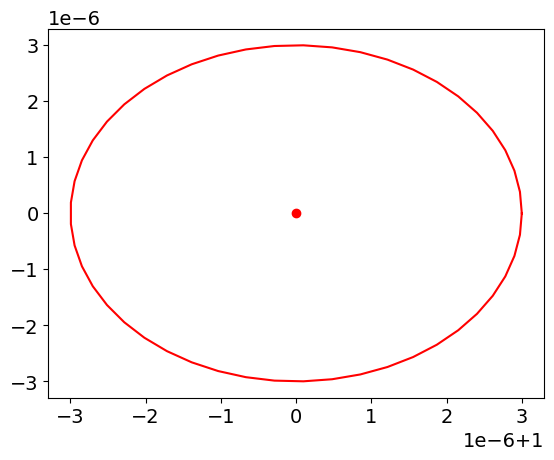

In [10]:
plot2dcov(iekf.mu_bar[:-1],
            iekf.Sigma_bar[:-1, :-1],
            'red', 3,
            legend='{} - IEKF')

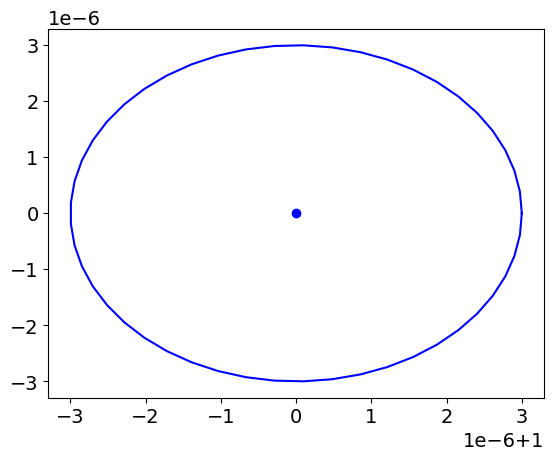

In [11]:
plot2dcov(iekf.mu[:-1],
            iekf.Sigma[:-1, :-1],
            'blue', 3,
            legend='{} - IEKF')

In [12]:
iekf.mu

array([1., 0., 0.])

In [13]:
u = np.array([0.1, 0, 0])
dt = 1

In [14]:
iekf.predict(u, dt)

In [15]:
g = np.array([0, 0, -9.81])
iekf.update(g)

(array([[ 0.        ,  0.04714423,  0.09037982],
        [-0.04714423,  0.        ,  0.        ],
        [-0.09037982,  0.        ,  0.        ]]),
 array([0.        , 8.69781003, 5.27301855]))

In [16]:
mrob.geometry.SO3([1.1, 0, 0]).mul(mrob.geometry.SO3(u*dt))

        1         0         0
        0  0.362358 -0.932039
        0  0.932039  0.362358

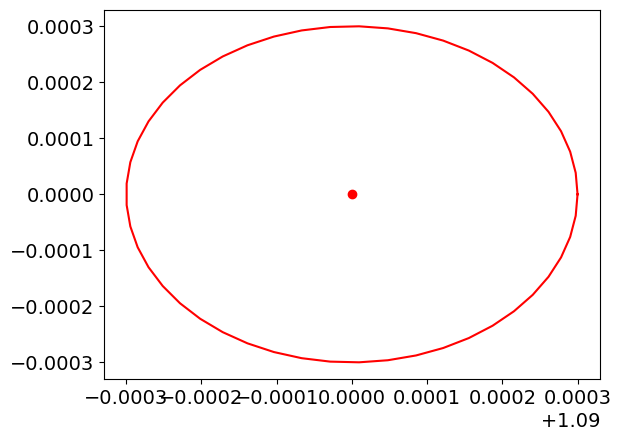

In [17]:
plot2dcov(iekf.mu_bar[:-1],
            iekf.Sigma_bar[:-1, :-1],
            'red', 3,
            legend='{} - IEKF')

In [18]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e0 * np.eye(3, 3)
Q = 1e-2 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0.1, 0])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = np.array([0.1, 0, 0])
dt = 1
N = 200
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
gt = np.empty((N, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))

In [19]:
for i in range(N):
    iekf.predict(u, dt)
    Ks[i], IVs[i] = iekf.update(mrob.geometry.SO3(np.random.normal(0, 0.1, 3)).R()@mrob.geometry.SO3(iekf.mu_bar).R().T@g)
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma
    gt[i] = mrob.geometry.SO3(iekf.mu_bar).Ln() #np.mod(u*(i+1)+np.pi, 2*np.pi) - np.pi

In [20]:
mrob.geometry.SO3([0.1, 0, 0]).R()

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99500417, -0.09983342],
       [ 0.        ,  0.09983342,  0.99500417]])

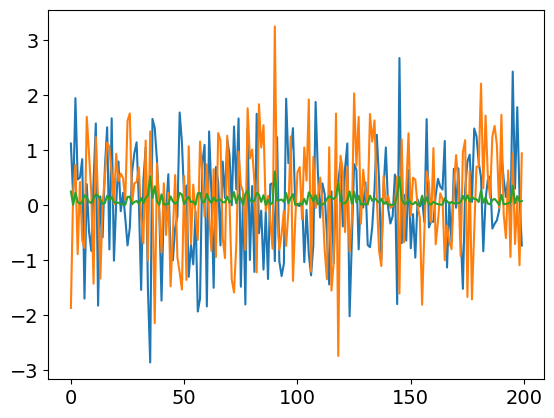

In [21]:
plt.plot(IVs)

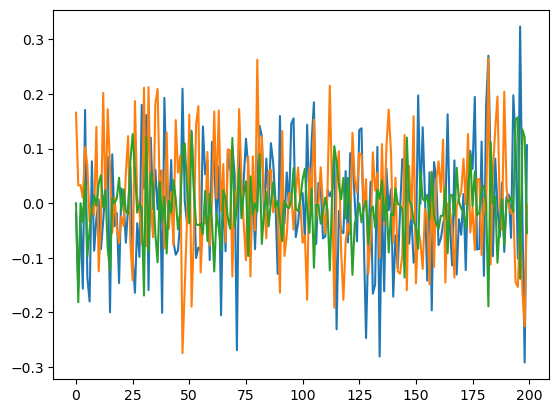

In [22]:
plt.plot(np.array([Ks[i] @ IVs[i] for i in range(len(Ks))]))

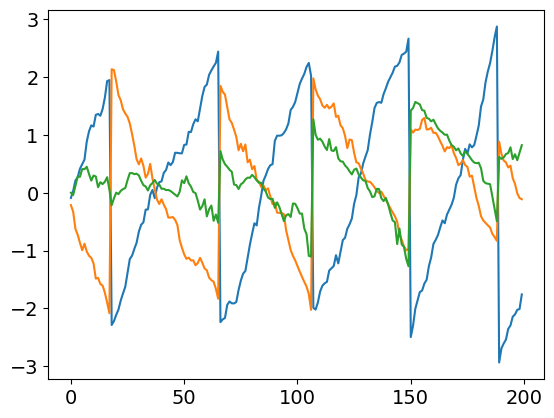

In [22]:
plt.plot(ups)

In [23]:
ups

array([[-8.95789593e-02, -2.13582382e-01,  2.87899737e-04],
       [ 3.10153064e-02, -3.27372907e-01, -3.90310805e-02],
       [ 2.12372934e-01, -6.25491489e-01,  1.23991862e-01],
       [ 2.68258918e-01, -7.26060444e-01,  2.79639433e-01],
       [ 4.15897535e-01, -8.66849609e-01,  2.76549767e-01],
       [ 4.93655233e-01, -9.94465026e-01,  4.09894905e-01],
       [ 5.74170573e-01, -8.81466725e-01,  4.08272510e-01],
       [ 8.84605490e-01, -1.01570739e+00,  4.49560072e-01],
       [ 1.06368160e+00, -1.09027199e+00,  3.24154361e-01],
       [ 1.16634437e+00, -1.12647991e+00,  2.10881407e-01],
       [ 1.14550600e+00, -1.22160784e+00,  2.97990304e-01],
       [ 1.34828243e+00, -1.48533358e+00,  2.81512486e-01],
       [ 1.36394886e+00, -1.47263473e+00,  9.61347500e-02],
       [ 1.33263725e+00, -1.57764548e+00,  1.83310218e-01],
       [ 1.44887823e+00, -1.60638525e+00,  1.50180324e-01],
       [ 1.64777103e+00, -1.72966250e+00,  1.91481642e-01],
       [ 1.93200279e+00, -1.90030345e+00

In [24]:
s_ups

array([[[ 1.43004167e-01, -2.39231257e-01, -1.22238942e+00],
        [-2.39231257e-01,  4.00604201e-01,  2.04641870e+00],
        [-1.22238942e+00,  2.04641870e+00,  1.04565995e+01]],

       [[ 2.36910840e-03,  3.54987777e-03, -1.47035652e-01],
        [ 3.54987777e-03,  5.66702446e-03, -2.30424143e-01],
        [-1.47035652e-01, -2.30424143e-01,  9.54425311e+00]],

       [[ 3.09097522e-01,  1.17036890e-01, -1.52405051e+00],
        [ 1.17036890e-01,  4.44337267e-02, -5.77261532e-01],
        [-1.52405051e+00, -5.77261532e-01,  7.51718447e+00]],

       ...,

       [[ 1.36549461e-01,  6.60347173e-03, -7.39795740e-01],
        [ 6.60347173e-03,  4.23484473e-04, -3.58034387e-02],
        [-7.39795740e-01, -3.58034387e-02,  4.01121085e+00]],

       [[ 1.08302226e-03, -6.92850658e-03, -6.17071902e-02],
        [-6.92850658e-03,  4.91317258e-02,  4.36655310e-01],
        [-6.17071902e-02,  4.36655310e-01,  3.88907633e+00]],

       [[ 2.58932978e-02, -3.29274237e-02,  3.41204049e-01],
 

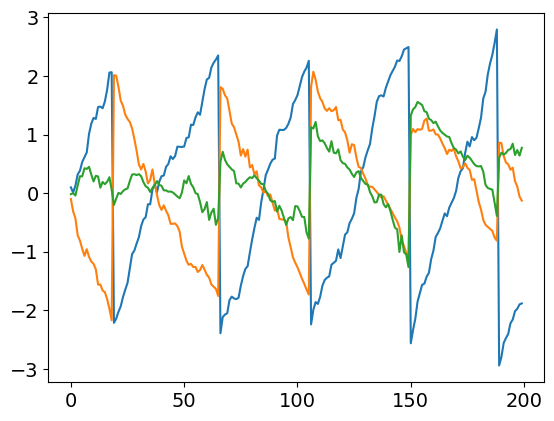

In [25]:
plt.plot(gt)

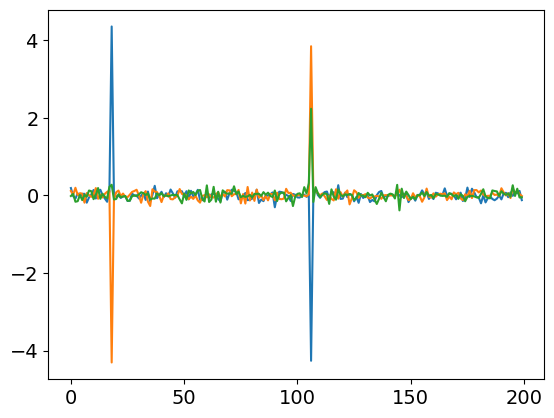

In [26]:
plt.plot(gt - ups)

In [27]:
def plot_covs(states, covs, state_i, gt):
    sigma = np.sqrt(covs[:, state_i, state_i])
    minus_sigma = states[:, state_i] - sigma
    plus_sigma = states[:, state_i] + sigma
    plt.figure(figsize=(14,8))
    t = np.array(range(len(states)))
    handles = ciplot(t, states[:, state_i], minus_sigma, plus_sigma, gt[:, state_i])


    plt.title('Direct Integration of Controls')
    plt.legend(handles, ['Estimated angle', 'Ground Truth'])
    plt.xlabel('Time')
    plt.ylabel('Translational Velocity')
    plt.show()

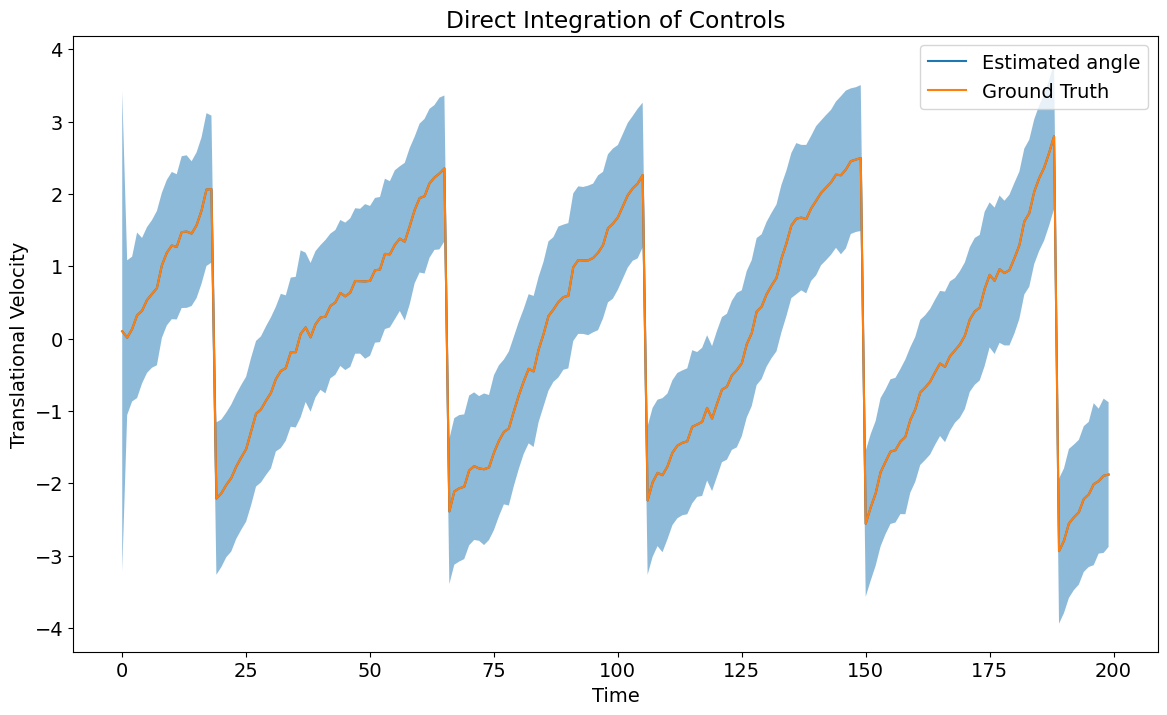

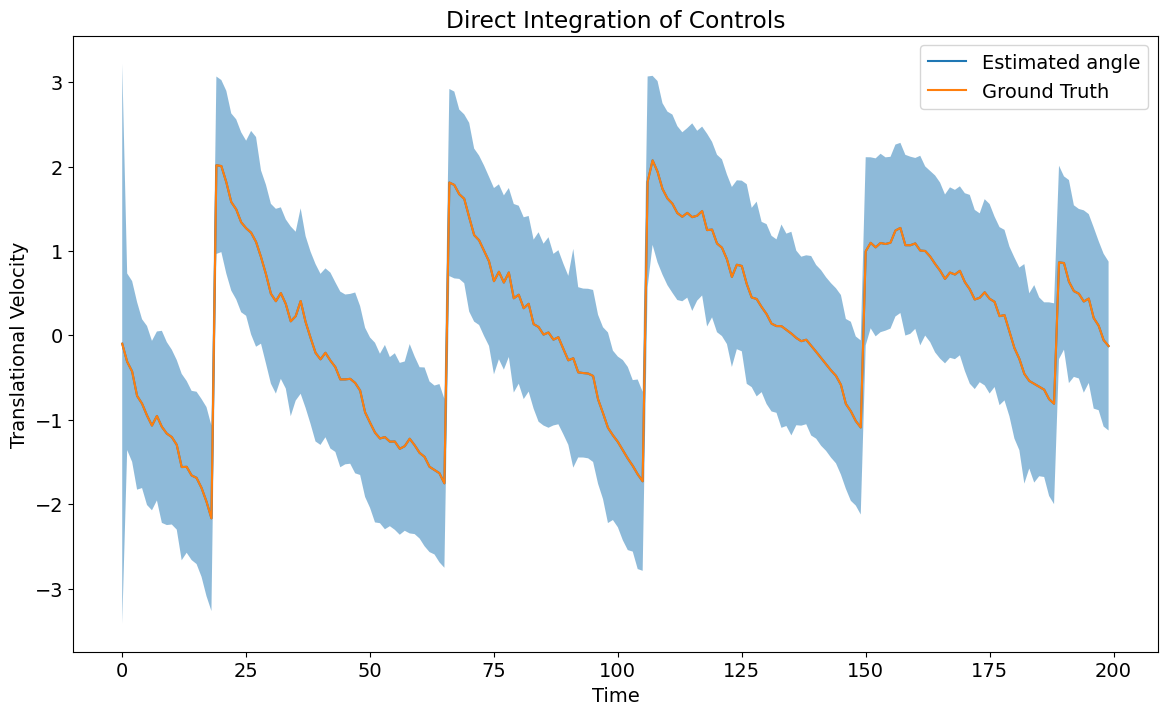

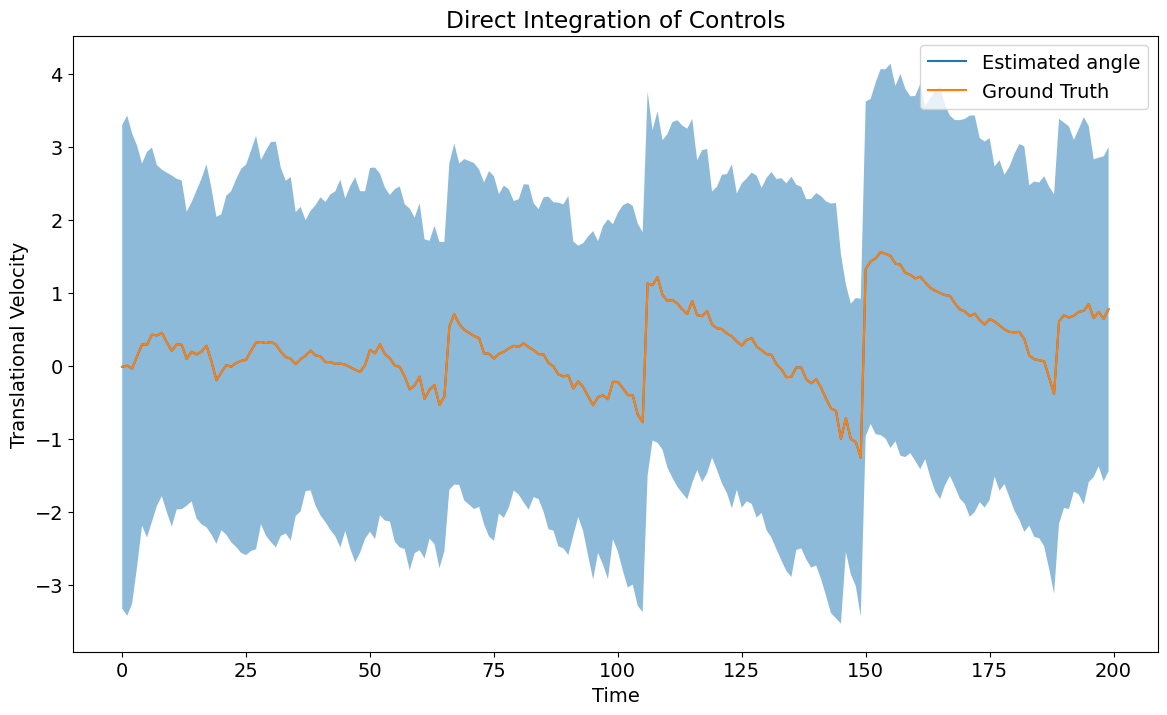

In [28]:
plot_covs(preds, s_preds, 0, gt)
plot_covs(preds, s_preds, 1, gt)
plot_covs(preds, s_preds, 2, gt)

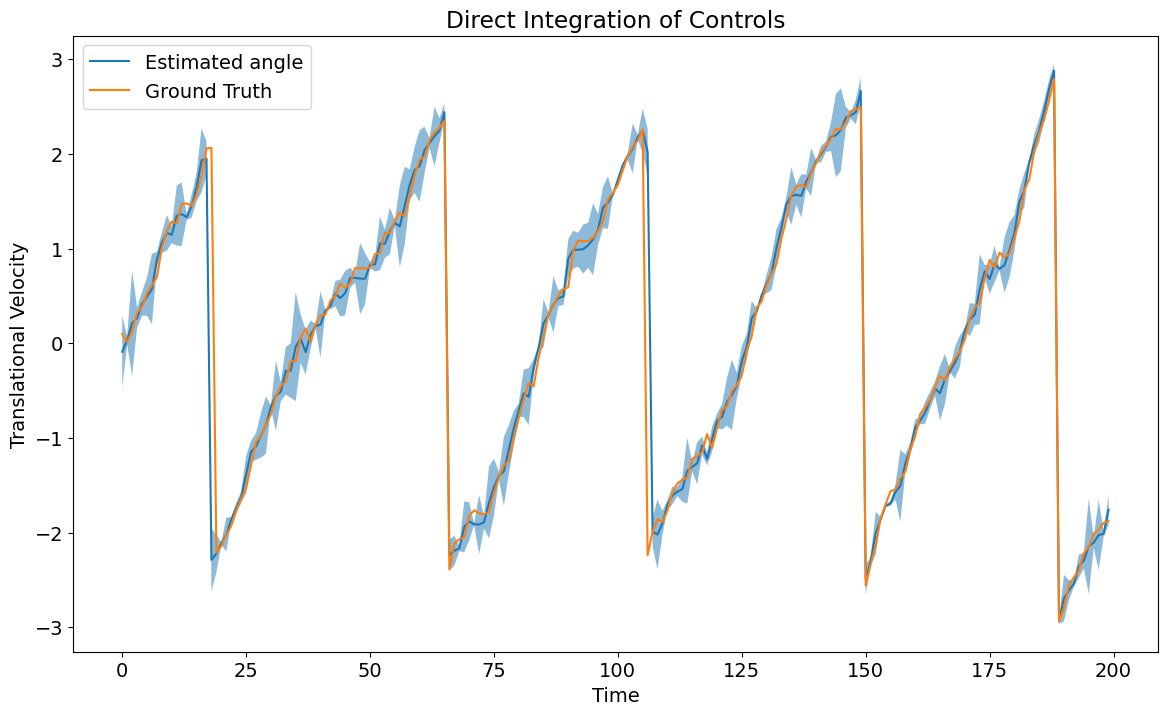

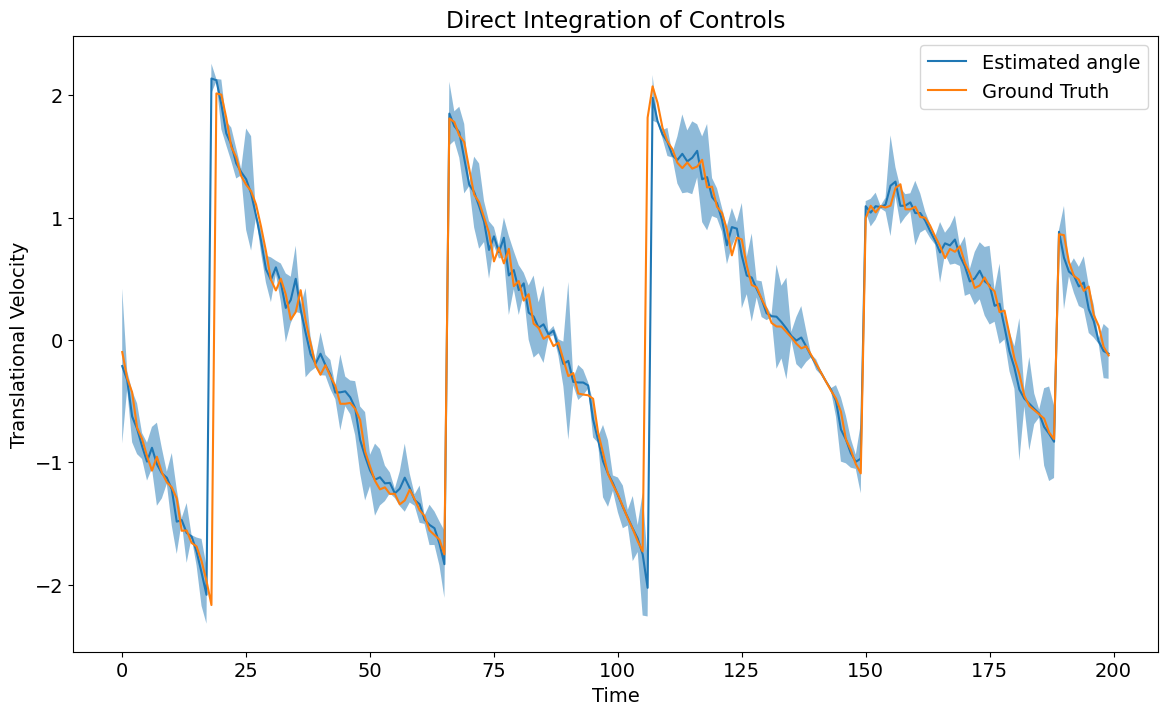

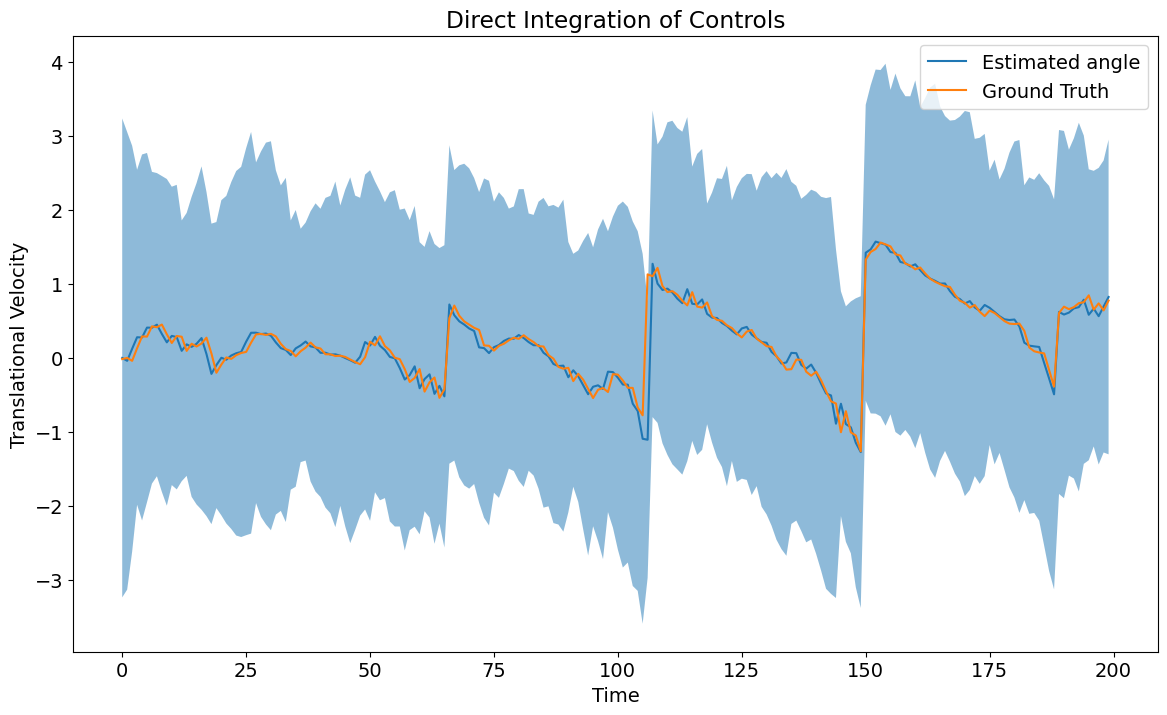

In [29]:
plot_covs(ups, s_ups, 0, gt)
plot_covs(ups, s_ups, 1, gt)
plot_covs(ups, s_ups, 2, gt)